# CDC

https://wonder.cdc.gov/

## Import

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import polars as pl
from sklearn.linear_model import LinearRegression

os.chdir("../../")
sys.path.insert(0, os.getcwd())

In [2]:
from morai.experience import charters
from morai.integrations import cdc
from morai.utils import helpers, sql

In [3]:
pd.options.display.float_format = "{:,.2f}".format

reference: https://github.com/alipphardt/cdc-wonder-api

In [4]:
db_filepath = r"files/integrations/cdc/cdc.sql"

In [5]:
import importlib

importlib.reload(cdc)
importlib.reload(sql)

<module 'morai.utils.sql' from 'C:\\Users\\johnk\\Desktop\\github\\morai\\morai\\utils\\sql.py'>

In [55]:
tables = sql.get_tables(db_filepath=db_filepath)
tables

['mcd99_check',
 'mcd18_check',
 'mi',
 'test',
 'mcd99_cod',
 'mcd18_cod',
 'mcd18_monthly']

## COD

### CDC Query
Querying the historical and provisional data

In [10]:
df = cdc.get_cdc_data_xml(xml_filename="mcd99_cod.xml")

In [11]:
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="mcd99_cod",
    if_exists="replace",
)

 2024-08-09 23:45:01 | morai.utils.sql | INFO     | replace data to SQLite database: `files/integrations/cdc/cdc.sql` and table: `mcd99_cod` 


In [12]:
df = cdc.get_cdc_data_xml(xml_filename="mcd18_cod.xml")

In [13]:
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="mcd18_cod",
    if_exists="replace",
)

 2024-08-09 23:45:06 | morai.utils.sql | INFO     | replace data to SQLite database: `files/integrations/cdc/cdc.sql` and table: `mcd18_cod` 


### SQL
Load from SQL database

In [14]:
mcd99_cod = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="mcd99_cod")

 2024-08-09 23:45:10 | morai.integrations.cdc | INFO     | table `mcd99_cod` last updated at: 2024-08-09 23:45:01, rows: 3354 


In [15]:
mcd18_cod = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="mcd18_cod")

 2024-08-09 23:45:11 | morai.integrations.cdc | INFO     | table `mcd18_cod` last updated at: 2024-08-09 23:45:06, rows: 1095 


### Aggregate
Aggregating the historical and provisional and mapping columns to more friendly names

In [16]:
# variable to map
category_col = "simple_grouping"

In [62]:
# filter and concat
mcd18_cod = mcd18_cod[mcd18_cod["year"] >= 2021]
cod_all = pd.concat([mcd99_cod, mcd18_cod], ignore_index=True)
# cod_all = cod_all[(cod_all["year"] != 2024)]

In [63]:
# map the variable from reference
cod_all = cdc.map_reference(
    df=cod_all, col=category_col, on_dict={"icd_-_sub-chapter": "wonder_sub_chapter"}
)

 2024-08-13 23:12:27 | morai.integrations.cdc | INFO     | mapping reference column: simple_grouping 


In [64]:
# create totals column
totals = cod_all.groupby("year").sum(numeric_only=True).reset_index()
totals[category_col] = "total"
cod_all = pd.concat([cod_all, totals], ignore_index=True)

In [65]:
category_orders = charters.get_category_orders(
    df=cod_all, category=category_col, measure="deaths"
)

### Predict

In [24]:
# train the data based on year and the category using linear regression
train_df = cod_all[(cod_all["year"] >= 2015) & (cod_all["year"] <= 2019)]
train_df = train_df.groupby(["year", category_col])["deaths"].sum().reset_index()

In [25]:
# create the models
models = {}
for cod in train_df[category_col].unique():
    cod_subset = train_df[train_df[category_col] == cod]
    X = (cod_subset["year"] - 2015).values.reshape(-1, 1)
    y = cod_subset["deaths"].values
    model = LinearRegression().fit(X, y)
    models[cod] = {
        "model": model,
        "coef": model.coef_[0],
        "intercept": model.intercept_,
    }

In [26]:
# make the predictions
test_df = cod_all[(cod_all["year"] >= 2020)]
test_df = test_df.groupby(["year", category_col])["deaths"].sum().reset_index()

for cod, model in models.items():
    mask = test_df[category_col] == cod
    if mask.sum() > 0:
        X = (test_df.loc[mask, "year"] - 2015).values.reshape(-1, 1)
        test_df.loc[mask, "pred"] = model["model"].predict(X)

test_df["diff_abs"] = test_df["deaths"] - test_df["pred"]
test_df["diff_pct"] = (test_df["deaths"] - test_df["pred"]) / test_df["pred"]

### Chart

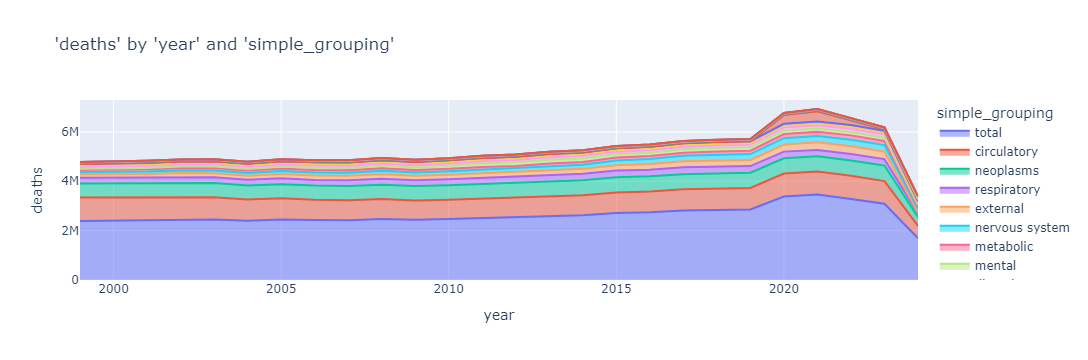

In [66]:
charters.chart(
    df=cod_all,
    x_axis="year",
    y_axis="deaths",
    color=category_col,
    type="area",
    category_orders=category_orders,
)

In [109]:
cod_all['crude_rate'] = cod_all['deaths'] / cod_all['population'] * 1000

In [112]:
cod_all[(cod_all['simple_grouping']=='neoplasms')&(cod_all['year']==2023)]

,year,icd_-_sub-chapter,deaths,population,crude_rate,added_at,simple_grouping
3689,2023,Malignant neoplasms,613352,333287557,1.84,2024-08-09 23:45:06,neoplasms
3690,2023,In situ neoplasms,97,333287557,0.00,2024-08-09 23:45:06,neoplasms
3691,2023,Benign neoplasms,1686,333287557,0.01,2024-08-09 23:45:06,neoplasms
3692,2023,Neoplasms of uncertain or unknown behaviour,14356,333287557,0.04,2024-08-09 23:45:06,neoplasms


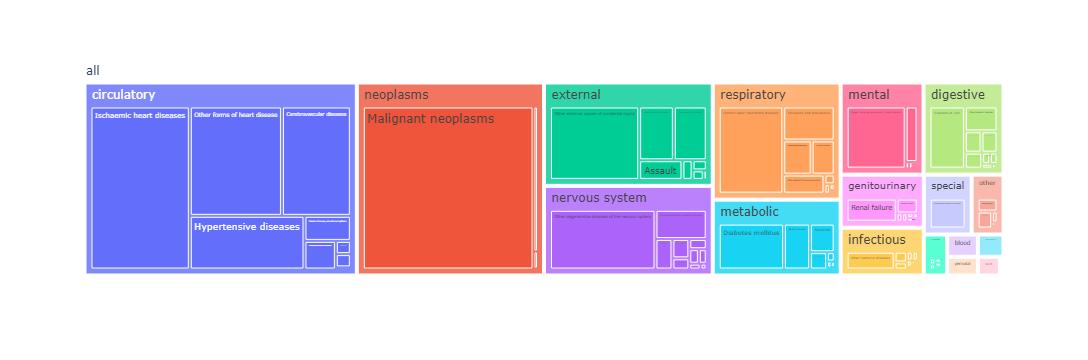

In [113]:
import plotly.express as px

fig = px.treemap(
    cod_all[(cod_all['simple_grouping']!='total')&(cod_all['year']==2023)],
    path=[px.Constant("all"), "simple_grouping", "icd_-_sub-chapter"],
    values="deaths",
    # color="crude_rate",
    # color_continuous_scale="armyrose",
    # color_continuous_midpoint=1,
)
fig

In [75]:
summary = charters.chart(
    df=test_df,
    x_axis="year",
    y_axis="diff_pct",
    color=category_col,
    type="area",
    category_orders=category_orders,
    display=False,
)
pivot = summary.pivot(index=category_col, columns="year", values="diff_pct")
pivot.index = pd.Categorical(
    pivot.index, categories=category_orders[category_col], ordered=True
)
pivot = pivot.sort_index().reset_index()
pivot

year,index,2020,2021,2022,2023
0,total,0.16,0.18,0.10,0.02
1,circulatory,0.05,0.04,0.04,-0.00
2,neoplasms,0.00,0.01,0.01,0.02
3,respiratory,-0.03,-0.11,-0.07,-0.08
4,external,0.08,0.15,0.12,0.06
5,nervous system,0.07,-0.02,-0.01,-0.06
6,metabolic,0.13,0.14,0.12,0.05
7,mental,0.11,0.02,0.04,-0.00
8,digestive,0.08,0.15,0.12,0.07
9,infectious,0.07,0.10,0.16,0.18


In [76]:
summary = charters.chart(
    df=test_df,
    x_axis="year",
    y_axis="diff_abs",
    color=category_col,
    type="area",
    category_orders=category_orders,
    display=False,
)
pivot = summary.pivot(index=category_col, columns="year", values="diff_abs")
pivot.index = pd.Categorical(
    pivot.index, categories=category_orders[category_col], ordered=True
)
pivot = pivot.sort_index()
pivot

year,2020,2021,2022,2023
total,"477,025.80","519,607.40","297,288.00","70,469.60"
circulatory,"41,580.80","34,006.00","33,668.20","-2,427.60"
neoplasms,"2,248.80","4,414.80","6,664.80","11,045.80"
respiratory,"-8,274.60","-29,565.40","-18,639.20","-22,527.00"
external,"20,727.80","41,228.40","32,671.00","17,129.60"
nervous system,"16,072.90","-5,624.20","-3,623.30","-15,349.40"
metabolic,"19,413.60","21,670.80","18,472.00","7,871.20"
mental,"14,318.80","2,491.80","5,332.80",-258.20
digestive,"9,645.40","17,524.00","14,363.60","7,988.20"
infectious,"4,533.30","6,473.20","9,534.10","10,495.00"


## Monthly

### CDC Query

In [35]:
df = cdc.get_cdc_data_xml(xml_filename="mcd18_monthly.xml", parse_date_col="Month")

In [36]:
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="mcd18_monthly",
    if_exists="replace",
)

 2024-08-09 23:56:02 | morai.utils.sql | INFO     | replace data to SQLite database: `files/integrations/cdc/cdc.sql` and table: `mcd18_monthly` 


### SQL

In [37]:
mcd18_monthly = cdc.get_cdc_data_sql(
    db_filepath=db_filepath, table_name="mcd18_monthly"
)

 2024-08-09 23:56:03 | morai.integrations.cdc | INFO     | table `mcd18_monthly` last updated at: 2024-08-09 23:56:02, rows: 79 


In [45]:
mcd18_monthly['added_at'].max()

'2024-08-09 23:56:02'

### Chart

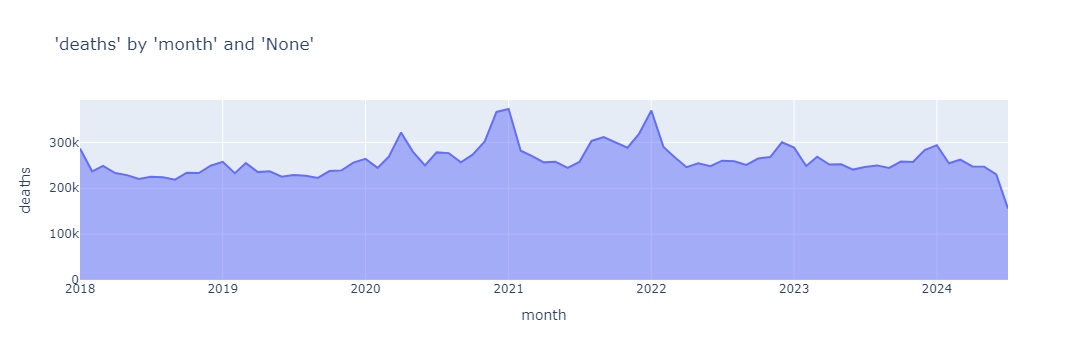

In [38]:
charters.chart(
    df=mcd18_monthly,
    x_axis="month",
    y_axis="deaths",
    type="area",
)

## MI

### CDC Query

In [259]:
df = cdc.get_cdc_data_xml(xml_filename="mcd99_mi.xml")
df["quintile"] = "total"
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="mi",
    if_exists="replace",
)
df = cdc.get_cdc_data_xml(xml_filename="mcd79_mi.xml")
df["quintile"] = "total"
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="mi",
)

 2024-07-30 23:39:26 | morai.utils.sql | INFO     | replace data to SQLite database: `files/integrations/cdc/cdc.sql` and table: `mi` 
 2024-07-30 23:39:29 | morai.utils.sql | INFO     | append data to SQLite database: `files/integrations/cdc/cdc.sql` and table: `mi` 


### SQL

In [47]:
mi = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="mi")

 2024-08-10 00:56:58 | morai.integrations.cdc | INFO     | table `mi` last updated at: 2024-07-30 23:39:29, rows: 1088 


### Aggregate

### Calculate

In [48]:
# filters
mi = mi[mi["year"] < 2020]

In [49]:
mi_df = cdc.calc_mi(df=mi, rolling=10)

 2024-08-10 00:57:02 | morai.integrations.cdc | INFO     | calculating mortality improvement by using a `2000 age adjusted` crude mortality rate 
 2024-08-10 00:57:02 | morai.integrations.cdc | INFO     | mapping reference column: value 
 2024-08-10 00:57:02 | morai.integrations.cdc | INFO     | mapping reference column: population_% 


### Chart

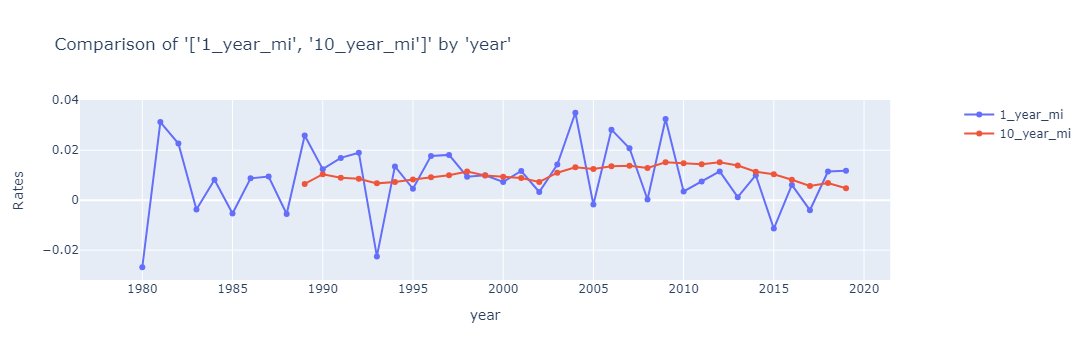

In [313]:
charters.compare_rates(
    df=mi_df,
    x_axis="year",
    rates=["1_year_mi", "10_year_mi"],
)

## Check

### CDC Query

In [80]:
df = cdc.get_cdc_data_xml(xml_filename="mcd99_check.xml")

In [81]:
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="mcd99_check",
    if_exists="replace",
)

 2024-07-30 22:02:12 | morai.utils.sql | INFO     | exporting data to SQLite database: files/integrations/cdc/cdc.sql and table: mcd99_check 


In [89]:
df = cdc.get_cdc_data_xml(xml_filename="mcd18_check.xml")

In [90]:
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="mcd18_check",
    if_exists="replace",
)

 2024-07-30 22:04:06 | morai.utils.sql | INFO     | exporting data to SQLite database: files/integrations/cdc/cdc.sql and table: mcd18_check 


### SQL

In [31]:
mcd99_check = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="mcd99_check")

 2024-08-09 23:54:34 | morai.integrations.cdc | INFO     | table `mcd99_check` last updated at: 2024-07-30 22:02:12, rows: 22 


In [32]:
mcd18_check = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="mcd18_check")

 2024-08-09 23:54:34 | morai.integrations.cdc | INFO     | table `mcd18_check` last updated at: 2024-07-30 22:04:06, rows: 7 


### Compare

In [33]:
cdc.compare_dfs(mcd99_check, mcd99_cod)

,year,deaths_left,deaths_right,deaths_diff
0,1999,2391399,2391293,106
1,2000,2403351,2403243,108
2,2001,2416425,2416324,101
3,2002,2443387,2443256,131
4,2003,2448288,2448203,85
5,2004,2397615,2397509,106
6,2005,2448017,2447915,102
7,2006,2426264,2426172,92
8,2007,2423712,2423597,115
9,2008,2471984,2471912,72


In [34]:
cdc.compare_dfs(mcd18_check, mcd18_cod)

,year,deaths_left,deaths_right,deaths_diff
0,2018,2839205,NaN,NaN
1,2019,2854838,NaN,NaN
2,2020,3383729,NaN,NaN
3,2021,3464231,"3,464,157.00",74.00
4,2022,3279857,"3,279,775.00",82.00
5,2023,3090967,"3,090,894.00",73.00
6,2024,1640826,"1,691,950.00","-51,124.00"


## Other Functions

In [293]:
sql.table_remove(db_filepath=db_filepath, table_name="test")

 2024-07-31 00:23:38 | morai.utils.sql | INFO     | table `test` removed from `files/integrations/cdc/cdc.sql` 


In [466]:
sql.table_dtypes(db_filepath=db_filepath, table_name="cod_monthly")

{'year': 'INTEGER',
 'month': 'TIMESTAMP',
 'deaths': 'INTEGER',
 'population': 'TEXT',
 'crude_rate': 'TEXT',
 'added_at': 'TEXT'}

## Test

In [302]:
df = cdc.get_cdc_data_txt(txt_filename="mcd99_mi_q5.txt")
df = df.rename(columns={'ten-year_age_groups': 'age_groups'})
df = df.drop(columns=["ten-year_age_groups_code", "gender_code", "year_code"])

In [303]:
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="test",
)

 2024-07-31 00:24:30 | morai.utils.sql | INFO     | append data to SQLite database: `files/integrations/cdc/cdc.sql` and table: `test` 


In [318]:
mi_test = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="test")

 2024-08-03 23:08:10 | morai.integrations.cdc | INFO     | table `test` last updated at: 2024-07-31 00:24:30, rows: 2321 
